In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os 
import sys

projRootPath =  os.path.abspath(os.path.join('.' ,"../.."))
print("Project root path is: ", projRootPath)
sys.path.append(projRootPath)

from src.utils.path_manipulation import contains_filetype
from src.utils.viz_functions import make_mel_spectrogram
from src.utils.sound_functions import mix_samples, read_mp3, write_mp3, pad_length_to_max

# modules for visuals
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

# modules for data processing
import numpy as np
from scipy import signal
from scipy.io import wavfile
from statistics import median
import wave
import struct
import csv
import random
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error 

# modules for data mining
from sklearn.decomposition import pca, FastICA

# and IPython.display for audio output
from tqdm.notebook import tqdm 
import IPython.display

# Librosa for audio
import librosa
# And the display module for visualization
import librosa.display

from pydub import AudioSegment

Project root path is:  D:\Programming\AudioMining


In [3]:
# Get data files
dataDirName = "data"
# rawDataDirName = os.path.join("raw", "mp3")
rawDataDirName = "converted_wav"
className1 = "violin"
className2 = "guitar"
data_path1 = os.path.join(projRootPath, dataDirName, rawDataDirName, className1)
data_path2 = os.path.join(projRootPath, dataDirName, rawDataDirName, className2)

# Get all files from data_path 
# r=root, d=directories, f = files
file_extension = ".wav"
(_, d, allFiles) = next(os.walk(data_path1))
soundFiles1 = [f for f in allFiles if f.endswith(file_extension)]

(_, d, allFiles) = next(os.walk(data_path2))
soundFiles2 = [f for f in allFiles if f.endswith(file_extension)]

In [34]:
# violin_note_file = "violin_C4_1_mezzo-piano_arco-normal.wav"
# violin_note_file = "violin_C4_phrase_forte_arco-staccato.wav"
# violin_note_file = "violin_A4_05_fortissimo_arco-normal.wav"
# violin_note_file = "violin_A4_1_fortissimo_arco-normal.wav"

# violin_note_file = "violin_C4_025_piano_arco-normal.wav"
# violin_note_file = "violin_C5_05_piano_arco-normal.wav"
violin_note_file = "violin_C6_1_piano_arco-normal.wav"
  

# guitar_note_file = "guitar_C4_very-long_forte_normal.wav"
# guitar_note_file = "guitar_C5_very-long_piano_harmonics.wav"
guitar_note_file = "guitar_C6_very-long_piano_normal.wav"

In [35]:
v_note, sampling_rate =  librosa.load(os.path.join(data_path1, violin_note_file), sr=44100)
g_note, sampling_rate =  librosa.load(os.path.join(data_path2, guitar_note_file), sr=44100)

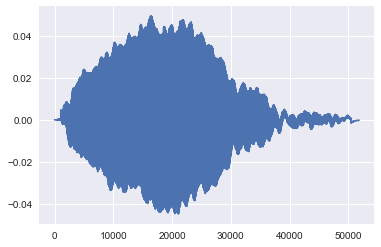

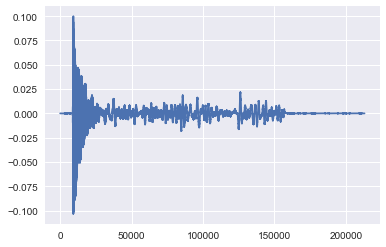

In [8]:
# plt.subplot(2, 1, 1)
plt.plot(v_note)
plt.show()
# plt.subplot(2, 1, 2)
plt.plot(g_note)
plt.show()

In [36]:
# take only a part of the read files and make them equal
v_note = v_note[:50000]
g_note = g_note[:50000]

# sdata1 = pad_length_to_max(sdata1, lenThreshold)
# sdata2 = pad_length_to_max(sdata2, lenThreshold)

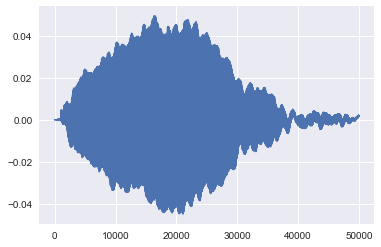

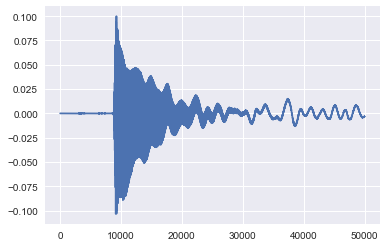

In [10]:
# plt.subplot(2, 1, 1)
plt.plot(v_note)
plt.show()
# plt.subplot(2, 1, 2)
plt.plot(g_note)
plt.show()

In [11]:
def generate_mixtures(s1, s2, mixing_matrix):
    S = np.c_[s1, s2]
    S = MinMaxScaler([-1, 1]).fit_transform(S)
    A = np.array(mixing_matrix)
    X = np.dot(S, A.T)
    return S, X

In [12]:
mixt_mtx = [[1, 1], [0.5, 1.5]]
S, mixts = generate_mixtures(v_note, g_note, mixt_mtx)

# print(mixts.shape)

ica = FastICA(n_components=2)
S_recov = ica.fit_transform(mixts) # Reconstruct signals
estimated_mix_mtx = ica.mixing_  # Get estimated mixing matrix

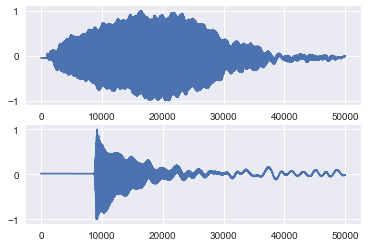

In [16]:
# Check that these are indeed the desired signals
plt.subplot(2, 1, 1)
plt.plot(S[:, 0])
plt.subplot(2, 1, 2)
plt.plot(S[:, 1])
plt.show()

In [14]:
IPython.display.Audio(S[:, 0], rate=sampling_rate)

In [15]:
IPython.display.Audio(S[:, 1], rate=sampling_rate)

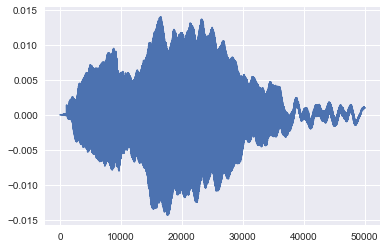

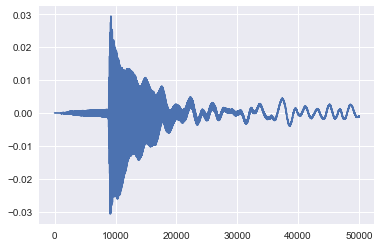

In [17]:
# These are reconstructed signals
# plt.subplot(2, 1, 1)
plt.plot(S_recov[:, 0])
plt.show()
# plt.subplot(2, 1, 2)
plt.plot(S_recov[:, 1])
plt.show()

In [18]:
IPython.display.Audio(S_recov[:, 0], rate=sampling_rate)

In [19]:
IPython.display.Audio(S_recov[:, 1], rate=sampling_rate)

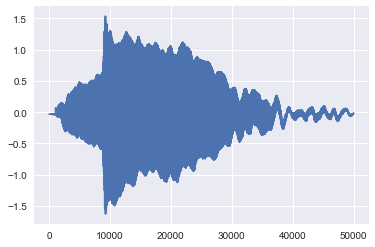

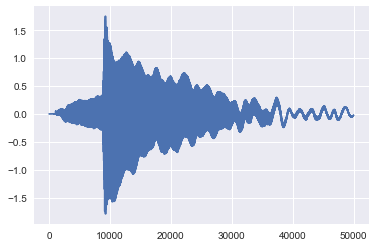

In [21]:
# Also see mixtures
# plt.subplot(2, 1, 1)
plt.plot(mixts[:, 0])
plt.show()
# plt.subplot(2, 1, 2)
plt.plot(mixts[:, 1])
plt.show()

In [22]:
IPython.display.Audio(mixts[:, 0], rate=sampling_rate)

In [23]:
IPython.display.Audio(mixts[:, 1], rate=sampling_rate)

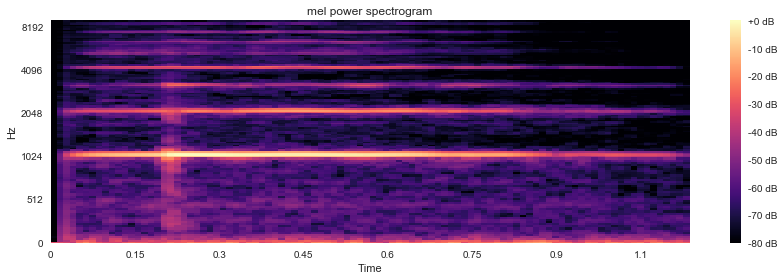

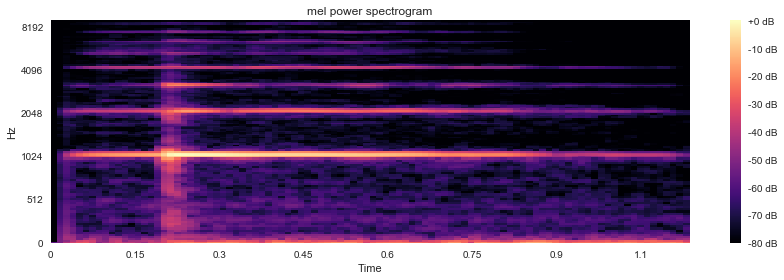

In [24]:
# Spectrograms for the mix

spectr = librosa.feature.melspectrogram(np.array(mixts[:, 0]), sr=sampling_rate, n_mels=128, fmax=9000)
# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(spectr, ref=np.max)
# Make a new figure
plt.figure(figsize=(12,4))
# Display the spectrogram on a mel scale
# sample rate and hop length parameters are used to render the time axis
librosa.display.specshow(log_S, sr=sampling_rate, x_axis='time', y_axis='mel', fmax=9000)
# Put a descriptive title on the plot
plt.title('mel power spectrogram')
# draw a color bar
plt.colorbar(format='%+02.0f dB')
# Make the figure layout compact
plt.tight_layout()

spectr = librosa.feature.melspectrogram(np.array(mixts[:, 1]), sr=sampling_rate, n_mels=128, fmax=9000)
# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(spectr, ref=np.max)
# Make a new figure
plt.figure(figsize=(12,4))
# Display the spectrogram on a mel scale
# sample rate and hop length parameters are used to render the time axis
librosa.display.specshow(log_S, sr=sampling_rate, x_axis='time', y_axis='mel', fmax=9000)
# Put a descriptive title on the plot
plt.title('mel power spectrogram')
# draw a color bar
plt.colorbar(format='%+02.0f dB')
# Make the figure layout compact
plt.tight_layout()



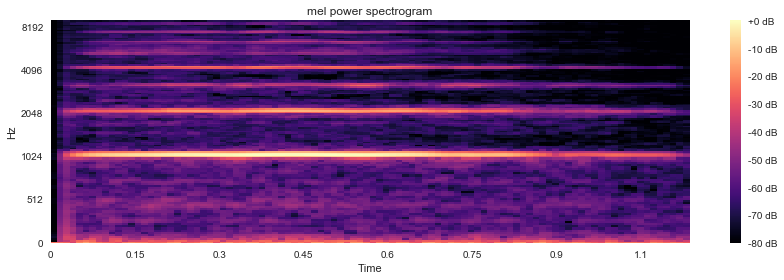

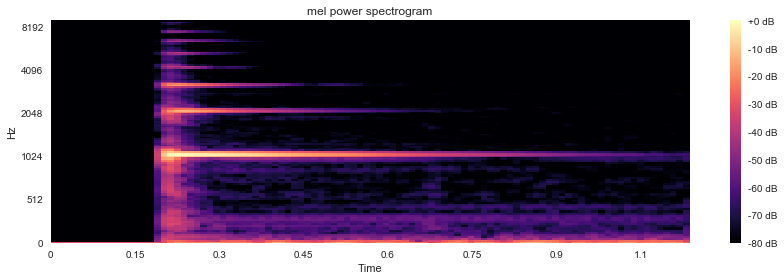

In [13]:
# Spectrograms for the original signals

spectr = librosa.feature.melspectrogram(np.array(S[:, 0]), sr=sampling_rate, n_mels=128, fmax=9000)
# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(spectr, ref=np.max)
# Make a new figure
plt.figure(figsize=(12,4))
# Display the spectrogram on a mel scale
# sample rate and hop length parameters are used to render the time axis
librosa.display.specshow(log_S, sr=sampling_rate, x_axis='time', y_axis='mel', fmax=9000)
# Put a descriptive title on the plot
plt.title('mel power spectrogram')
# draw a color bar
plt.colorbar(format='%+02.0f dB')
# Make the figure layout compact
plt.tight_layout()

spectr = librosa.feature.melspectrogram(np.array(S[:, 1]), sr=sampling_rate, n_mels=128, fmax=9000)
# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(spectr, ref=np.max)
# Make a new figure
plt.figure(figsize=(12,4))
# Display the spectrogram on a mel scale
# sample rate and hop length parameters are used to render the time axis
librosa.display.specshow(log_S, sr=sampling_rate, x_axis='time', y_axis='mel', fmax=9000)
# Put a descriptive title on the plot
plt.title('mel power spectrogram')
# draw a color bar
plt.colorbar(format='%+02.0f dB')
# Make the figure layout compact
plt.tight_layout()


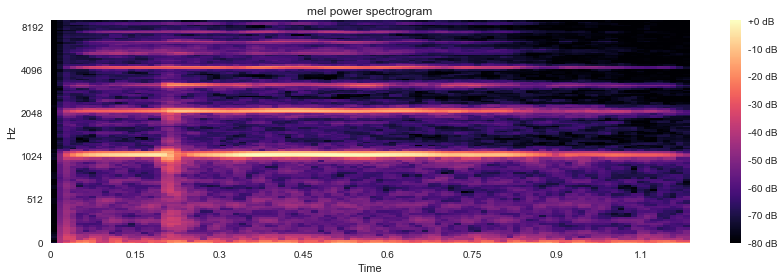

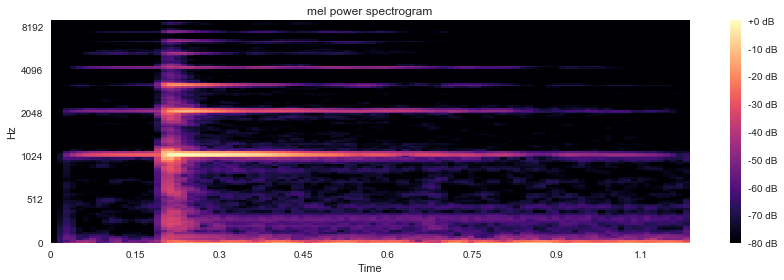

In [25]:
# Spectrograms for the recovered signals

spectr = librosa.feature.melspectrogram(np.array(S_recov[:, 0]), sr=sampling_rate, n_mels=128, fmax=9000)
# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(spectr, ref=np.max)
# Make a new figure
plt.figure(figsize=(12,4))
# Display the spectrogram on a mel scale
# sample rate and hop length parameters are used to render the time axis
librosa.display.specshow(log_S, sr=sampling_rate, x_axis='time', y_axis='mel', fmax=9000)
# Put a descriptive title on the plot
plt.title('mel power spectrogram')
# draw a color bar
plt.colorbar(format='%+02.0f dB')
# Make the figure layout compact
plt.tight_layout()

spectr = librosa.feature.melspectrogram(np.array(S_recov[:, 1]), sr=sampling_rate, n_mels=128, fmax=9000)
# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(spectr, ref=np.max)
# Make a new figure
plt.figure(figsize=(12,4))
# Display the spectrogram on a mel scale
# sample rate and hop length parameters are used to render the time axis
librosa.display.specshow(log_S, sr=sampling_rate, x_axis='time', y_axis='mel', fmax=9000)
# Put a descriptive title on the plot
plt.title('mel power spectrogram')
# draw a color bar
plt.colorbar(format='%+02.0f dB')
# Make the figure layout compact
plt.tight_layout()


In [38]:
# Increase number of observations

mixt_mtx1 = [[1, 1], [0.5, 1.5], [1.1, 1.1], [1.2, 0.8], [0.4, 0.4]]
S1, mixts1 = generate_mixtures(v_note, g_note, mixt_mtx1)

# print(mixts.shape)

ica = FastICA(n_components=2)
S_recov1 = ica.fit_transform(mixts1) # Reconstruct signals
estimated_mix_mtx1 = ica.mixing_  # Get estimated mixing matrix

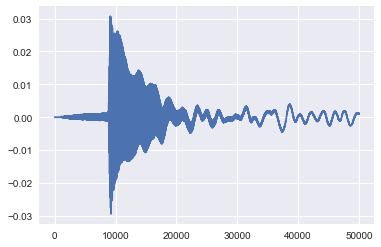

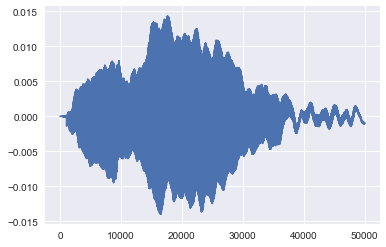

In [40]:
# These are reconstructed signals
# plt.subplot(2, 1, 1)
plt.plot(S_recov1[:, 0])
plt.show()
# plt.subplot(2, 1, 2)
plt.plot(S_recov1[:, 1])
plt.show()

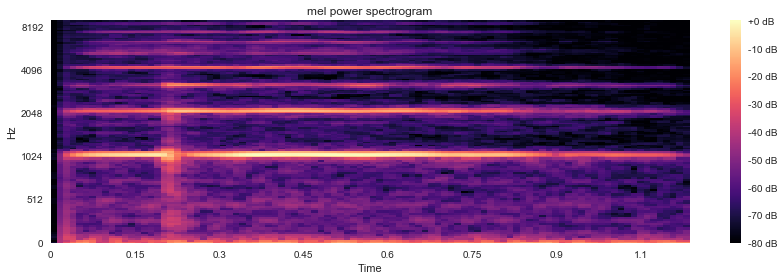

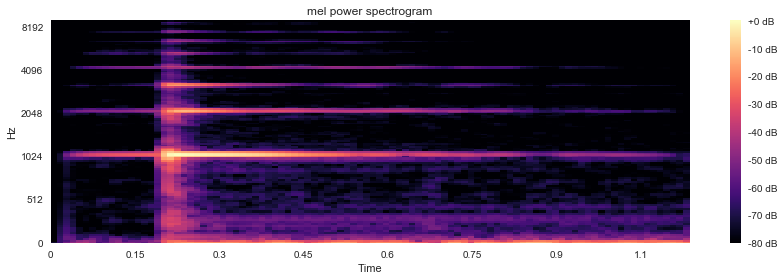

In [28]:
# Spectrograms for the recovered signals

spectr = librosa.feature.melspectrogram(np.array(S_recov1[:, 0]), sr=sampling_rate, n_mels=128, fmax=9000)
# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(spectr, ref=np.max)
# Make a new figure
plt.figure(figsize=(12,4))
# Display the spectrogram on a mel scale
# sample rate and hop length parameters are used to render the time axis
librosa.display.specshow(log_S, sr=sampling_rate, x_axis='time', y_axis='mel', fmax=9000)
# Put a descriptive title on the plot
plt.title('mel power spectrogram')
# draw a color bar
plt.colorbar(format='%+02.0f dB')
# Make the figure layout compact
plt.tight_layout()

spectr = librosa.feature.melspectrogram(np.array(S_recov1[:, 1]), sr=sampling_rate, n_mels=128, fmax=9000)
# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(spectr, ref=np.max)
# Make a new figure
plt.figure(figsize=(12,4))
# Display the spectrogram on a mel scale
# sample rate and hop length parameters are used to render the time axis
librosa.display.specshow(log_S, sr=sampling_rate, x_axis='time', y_axis='mel', fmax=9000)
# Put a descriptive title on the plot
plt.title('mel power spectrogram')
# draw a color bar
plt.colorbar(format='%+02.0f dB')
# Make the figure layout compact
plt.tight_layout()

In [29]:
IPython.display.Audio(S_recov1[:, 0], rate=sampling_rate)

In [30]:
IPython.display.Audio(S_recov1[:, 1], rate=sampling_rate)

In [31]:
IPython.display.Audio(S_recov[:, 0], rate=sampling_rate)

In [32]:
IPython.display.Audio(S_recov[:, 1], rate=sampling_rate)

In [41]:
# violin_note_file = "violin_C4_1_mezzo-piano_arco-normal.wav"
# violin_note_file = "violin_C4_phrase_forte_arco-staccato.wav"
# violin_note_file = "violin_A4_05_fortissimo_arco-normal.wav"
# violin_note_file = "violin_A4_1_fortissimo_arco-normal.wav"

# violin_note_file = "violin_C4_025_piano_arco-normal.wav"
# violin_note_file = "violin_C5_05_piano_arco-normal.wav"
violin_note_file = "violin_C6_1_piano_arco-normal.wav"
  

guitar_note_file = "guitar_C4_very-long_forte_normal.wav"
# guitar_note_file = "guitar_C5_very-long_piano_harmonics.wav"
# guitar_note_file = "guitar_C6_very-long_piano_normal.wav"

In [42]:
v_note, sampling_rate =  librosa.load(os.path.join(data_path1, violin_note_file), sr=44100)
g_note, sampling_rate =  librosa.load(os.path.join(data_path2, guitar_note_file), sr=44100)

In [43]:
# take only a part of the read files and make them equal
v_note = v_note[:50000]
g_note = g_note[:50000]

# sdata1 = pad_length_to_max(sdata1, lenThreshold)
# sdata2 = pad_length_to_max(sdata2, lenThreshold)

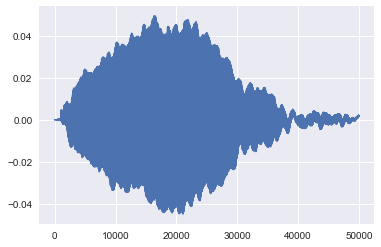

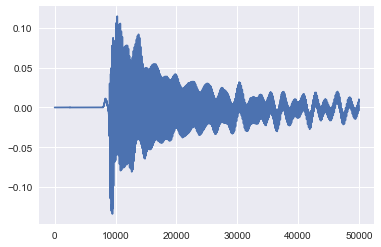

In [45]:
# These are reconstructed signals
# plt.subplot(2, 1, 1)
plt.plot(v_note)
plt.show()
# plt.subplot(2, 1, 2)
plt.plot(g_note)
plt.show()

In [44]:
mixt_mtx = [[1, 1], [0.5, 1.5]]
S, mixts = generate_mixtures(v_note, g_note, mixt_mtx)

# print(mixts.shape)

ica = FastICA(n_components=2)
S_recov = ica.fit_transform(mixts) # Reconstruct signals
estimated_mix_mtx = ica.mixing_  # Get estimated mixing matrix

In [ ]:
# Check that these are indeed the desired signals
plt.subplot(2, 1, 1)
plt.plot(S[:, 0])
plt.subplot(2, 1, 2)
plt.plot(S[:, 1])
plt.show()

In [48]:
IPython.display.Audio(S[:, 0], rate=sampling_rate)

In [49]:
IPython.display.Audio(S[:, 1], rate=sampling_rate)

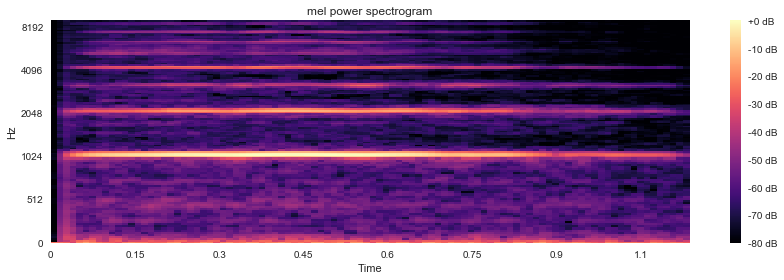

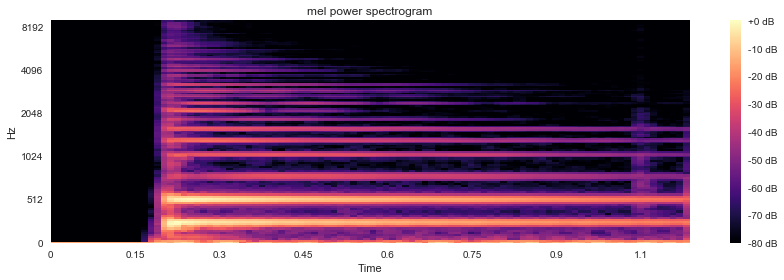

In [50]:
# Spectrograms for the original signals

spectr = librosa.feature.melspectrogram(np.array(S[:, 0]), sr=sampling_rate, n_mels=128, fmax=9000)
# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(spectr, ref=np.max)
# Make a new figure
plt.figure(figsize=(12,4))
# Display the spectrogram on a mel scale
# sample rate and hop length parameters are used to render the time axis
librosa.display.specshow(log_S, sr=sampling_rate, x_axis='time', y_axis='mel', fmax=9000)
# Put a descriptive title on the plot
plt.title('mel power spectrogram')
# draw a color bar
plt.colorbar(format='%+02.0f dB')
# Make the figure layout compact
plt.tight_layout()

spectr = librosa.feature.melspectrogram(np.array(S[:, 1]), sr=sampling_rate, n_mels=128, fmax=9000)
# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(spectr, ref=np.max)
# Make a new figure
plt.figure(figsize=(12,4))
# Display the spectrogram on a mel scale
# sample rate and hop length parameters are used to render the time axis
librosa.display.specshow(log_S, sr=sampling_rate, x_axis='time', y_axis='mel', fmax=9000)
# Put a descriptive title on the plot
plt.title('mel power spectrogram')
# draw a color bar
plt.colorbar(format='%+02.0f dB')
# Make the figure layout compact
plt.tight_layout()

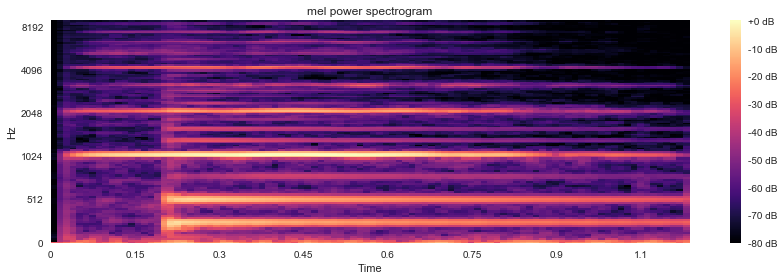

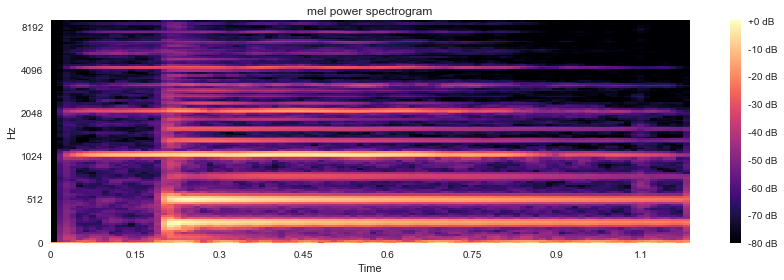

In [51]:
# Spectrograms for the mix

spectr = librosa.feature.melspectrogram(np.array(mixts[:, 0]), sr=sampling_rate, n_mels=128, fmax=9000)
# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(spectr, ref=np.max)
# Make a new figure
plt.figure(figsize=(12,4))
# Display the spectrogram on a mel scale
# sample rate and hop length parameters are used to render the time axis
librosa.display.specshow(log_S, sr=sampling_rate, x_axis='time', y_axis='mel', fmax=9000)
# Put a descriptive title on the plot
plt.title('mel power spectrogram')
# draw a color bar
plt.colorbar(format='%+02.0f dB')
# Make the figure layout compact
plt.tight_layout()

spectr = librosa.feature.melspectrogram(np.array(mixts[:, 1]), sr=sampling_rate, n_mels=128, fmax=9000)
# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(spectr, ref=np.max)
# Make a new figure
plt.figure(figsize=(12,4))
# Display the spectrogram on a mel scale
# sample rate and hop length parameters are used to render the time axis
librosa.display.specshow(log_S, sr=sampling_rate, x_axis='time', y_axis='mel', fmax=9000)
# Put a descriptive title on the plot
plt.title('mel power spectrogram')
# draw a color bar
plt.colorbar(format='%+02.0f dB')
# Make the figure layout compact
plt.tight_layout()


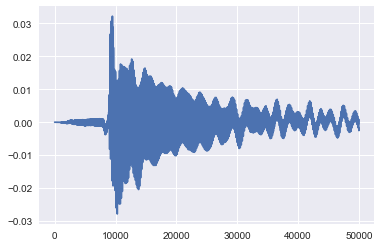

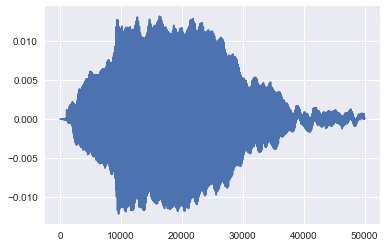

In [53]:
# These are reconstructed signals
# plt.subplot(2, 1, 1)
plt.plot(S_recov[:, 0])
plt.show()
# plt.subplot(2, 1, 2)
plt.plot(S_recov[:, 1])
plt.show()

In [54]:
IPython.display.Audio(S_recov[:, 0], rate=sampling_rate)

In [55]:
IPython.display.Audio(S_recov[:, 1], rate=sampling_rate)

In [ ]:
# Spectrograms for the recovered signals

spectr = librosa.feature.melspectrogram(np.array(S_recov[:, 0]), sr=sampling_rate, n_mels=128, fmax=9000)
# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(spectr, ref=np.max)
# Make a new figure
plt.figure(figsize=(12,4))
# Display the spectrogram on a mel scale
# sample rate and hop length parameters are used to render the time axis
librosa.display.specshow(log_S, sr=sampling_rate, x_axis='time', y_axis='mel', fmax=9000)
# Put a descriptive title on the plot
plt.title('mel power spectrogram')
# draw a color bar
plt.colorbar(format='%+02.0f dB')
# Make the figure layout compact
plt.tight_layout()

spectr = librosa.feature.melspectrogram(np.array(S_recov[:, 1]), sr=sampling_rate, n_mels=128, fmax=9000)
# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(spectr, ref=np.max)
# Make a new figure
plt.figure(figsize=(12,4))
# Display the spectrogram on a mel scale
# sample rate and hop length parameters are used to render the time axis
librosa.display.specshow(log_S, sr=sampling_rate, x_axis='time', y_axis='mel', fmax=9000)
# Put a descriptive title on the plot
plt.title('mel power spectrogram')
# draw a color bar
plt.colorbar(format='%+02.0f dB')
# Make the figure layout compact
plt.tight_layout()

In [65]:
mixt_mtx1 = [[1, 1], [0.5, 1.5], [1.1, 1.1], [1.2, 0.8], [0.4, 0.4]]
S1, mixts1 = generate_mixtures(v_note, g_note, mixt_mtx1)

# print(mixts.shape)

ica = FastICA(n_components=2)
S_recov1 = ica.fit_transform(mixts1) # Reconstruct signals
estimated_mix_mtx1 = ica.mixing_  # Get estimated mixing matrix

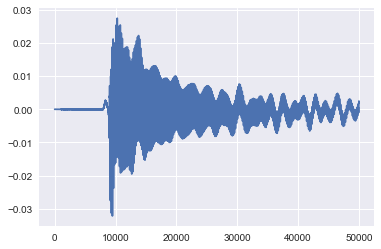

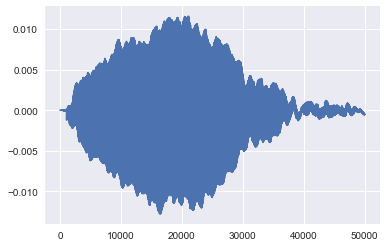

In [66]:
# These are reconstructed signals
# plt.subplot(2, 1, 1)
plt.plot(S_recov1[:, 0])
plt.show()
# plt.subplot(2, 1, 2)
plt.plot(S_recov1[:, 1])
plt.show()

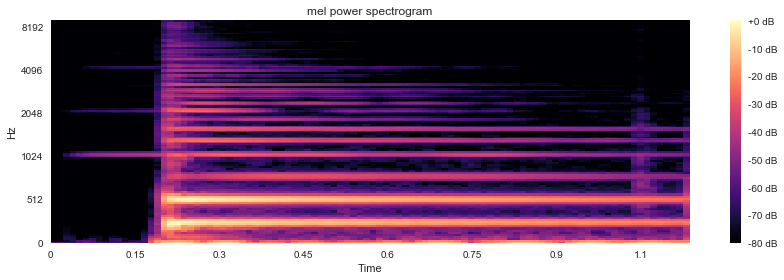

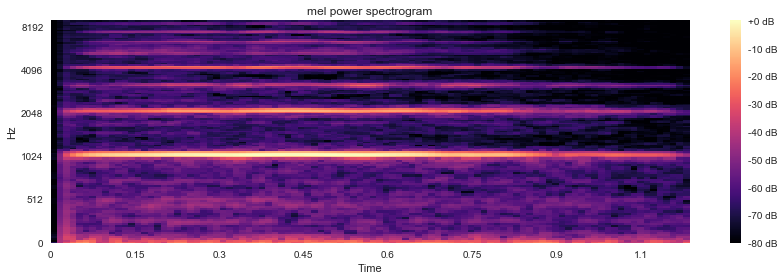

In [67]:
# Spectrograms for the recovered signals

spectr = librosa.feature.melspectrogram(np.array(S_recov1[:, 0]), sr=sampling_rate, n_mels=128, fmax=9000)
# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(spectr, ref=np.max)
# Make a new figure
plt.figure(figsize=(12,4))
# Display the spectrogram on a mel scale
# sample rate and hop length parameters are used to render the time axis
librosa.display.specshow(log_S, sr=sampling_rate, x_axis='time', y_axis='mel', fmax=9000)
# Put a descriptive title on the plot
plt.title('mel power spectrogram')
# draw a color bar
plt.colorbar(format='%+02.0f dB')
# Make the figure layout compact
plt.tight_layout()

spectr = librosa.feature.melspectrogram(np.array(S_recov1[:, 1]), sr=sampling_rate, n_mels=128, fmax=9000)
# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(spectr, ref=np.max)
# Make a new figure
plt.figure(figsize=(12,4))
# Display the spectrogram on a mel scale
# sample rate and hop length parameters are used to render the time axis
librosa.display.specshow(log_S, sr=sampling_rate, x_axis='time', y_axis='mel', fmax=9000)
# Put a descriptive title on the plot
plt.title('mel power spectrogram')
# draw a color bar
plt.colorbar(format='%+02.0f dB')
# Make the figure layout compact
plt.tight_layout()

In [68]:
IPython.display.Audio(S_recov1[:, 0], rate=sampling_rate)

In [69]:
IPython.display.Audio(S_recov1[:, 1], rate=sampling_rate)

In [70]:
mixt_mtx1 = [[1, 1], [1, 1], [1, 1]]
S1, mixts1 = generate_mixtures(v_note, g_note, mixt_mtx1)

# print(mixts.shape)

ica = FastICA(n_components=2)
S_recov1 = ica.fit_transform(mixts1) # Reconstruct signals
estimated_mix_mtx1 = ica.mixing_  # Get estimated mixing matrix

In [71]:
IPython.display.Audio(S_recov1[:, 0], rate=sampling_rate)

In [72]:
IPython.display.Audio(S_recov1[:, 1], rate=sampling_rate)

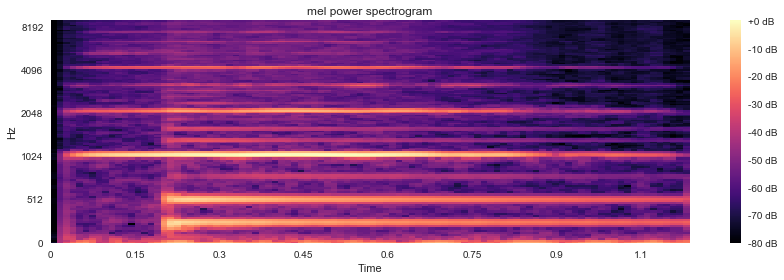

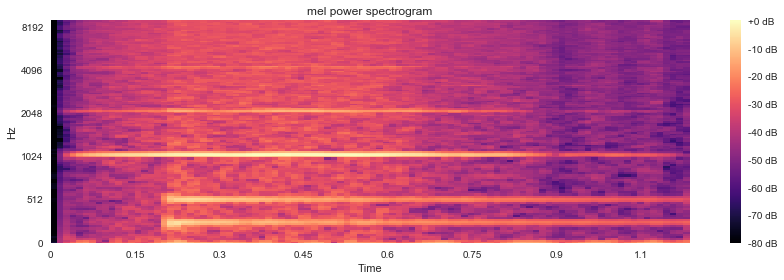

In [73]:
# Spectrograms for the recovered signals

spectr = librosa.feature.melspectrogram(np.array(S_recov1[:, 0]), sr=sampling_rate, n_mels=128, fmax=9000)
# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(spectr, ref=np.max)
# Make a new figure
plt.figure(figsize=(12,4))
# Display the spectrogram on a mel scale
# sample rate and hop length parameters are used to render the time axis
librosa.display.specshow(log_S, sr=sampling_rate, x_axis='time', y_axis='mel', fmax=9000)
# Put a descriptive title on the plot
plt.title('mel power spectrogram')
# draw a color bar
plt.colorbar(format='%+02.0f dB')
# Make the figure layout compact
plt.tight_layout()

spectr = librosa.feature.melspectrogram(np.array(S_recov1[:, 1]), sr=sampling_rate, n_mels=128, fmax=9000)
# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(spectr, ref=np.max)
# Make a new figure
plt.figure(figsize=(12,4))
# Display the spectrogram on a mel scale
# sample rate and hop length parameters are used to render the time axis
librosa.display.specshow(log_S, sr=sampling_rate, x_axis='time', y_axis='mel', fmax=9000)
# Put a descriptive title on the plot
plt.title('mel power spectrogram')
# draw a color bar
plt.colorbar(format='%+02.0f dB')
# Make the figure layout compact
plt.tight_layout()